In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import math
from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

In [2]:
import sys
sys.path.append('../')
from inference.read_in_data import *
from inference.correlation_heatmap import *
from inference.calculating_tau import *

# Viscosity of 0.05% glycerol (4 uL glycerol + 196 uL)

viscosity from Rheometer data: 0.588 Pa*S

In [3]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.6285 # Pa*S
r=52*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

6.723490393026199e-15


# 0.05% 100nm in diameter PS beads in glycerol (10x Objective)

## 2d scan

In [4]:
video_time_length=60 #s
imgname='0p2ps_beads__new_inglycerol_405laser_10xobj_0p52au_60s_1avg_height100um'
foldername='/Volumes/WENYUN WANG/20230120/'

In [5]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

### Temporal Autocorrelation

In [6]:
def compute_g2t_wo_kernel(px,laglist_g2t,normalize=True):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=5000 #len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    return g2t

In [7]:
laglist_g2t=range(0,100,1)
px=[10,300]
g2t=compute_g2t_wo_kernel(px,laglist_g2t)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t,'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

IndexError: list index out of range

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[0:50],plateau,np.array(g2t[0:50]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

#### average over pixels

In [ ]:
laglist_g2t=range(0,100,1)
averaged_g2t=[]
for y in range(0,20,1):
    for x in range(10,30,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [ ]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p',"wb"))

In [ ]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg_temporal.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1) # assumes that the laglist is calculated is consective
lagtime_g2t= [element * framespeed for element in laglist_g2t]

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

### TRC

In [ ]:
# for one pixel

#kernel_size is half of the total window size
def TRC(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest,normalize=True):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
        if normalize:
            first=correlation_2d[t,0]
            for tau in tau_interest:
                correlation_2d[t,tau]=correlation_2d[t,tau]/first
    return correlation_2d

In [ ]:
laglist_g2t=range(0,100,1)
t_range=range(0,50,1)
TRC_corr=TRC([10,300],10,125,t_range,laglist_g2t)

In [ ]:
pickle.dump(TRC_corr, open(foldername+imgname+'_g2tcorrrelation_avg_TRC.p',"wb"))

In [ ]:
laglist_g2t=range(0,100,1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.plot(lagtime_g2t,TRC_corr[20,:],'.')
plt.legend(['TRC vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("TRC",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(TRC_corr[10,:]),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[:50],plateau,np.array(TRC_corr[10,:50]),a,b)
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

### Average over spatial and temporal

In [ ]:
# for one pixel
def spatial_temporal(pixel,kernel_size_y, kernel_size_x, t_interest, tau_interest, normalize=True):
    correlation=np.zeros(len(tau_interest))
    
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size_y, 2*kernel_size_x))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size_y, y+kernel_size_y)):
        for xindex, j in enumerate(range(x-kernel_size_x, x+kernel_size_x)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size_x)*(2*kernel_size_y)
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation

    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
    if normalize:
        first=correlation[0]
        for tau in tau_interest:
            correlation[tau]=correlation[tau]/first   
    

    return correlation

In [ ]:
laglist_g2t=range(0,100,1)
t_range=range(0,70,1)
spatemp_corr=spatial_temporal([10,300],1,18,t_range,laglist_g2t)

In [ ]:
pickle.dump(spatemp_corr, open(foldername+imgname+'_g2tcorrrelation_avg_spatemp.p',"wb"))

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.plot(lagtime_g2t,spatemp_corr[:],'.')
plt.legend(['Spatial temporal vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("Average over space and time",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(spatemp_corr[:]),lagtime_g2t,1,10, True)

In [ ]:
reconstruct(lagtime_g2t[:50],plateau,np.array(spatemp_corr[:50]),a,b)
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

In [ ]:
print(q)

In [ ]:
2*k*np.sin(np.radians(180/2))*10**(9)*n

In [ ]:
2*k*np.sin(np.radians(199.77/2))*10**(9)*n

## line scanning

In [8]:
video_time_length=10
imgname='0p05ps_beads_inglycerol_405laser_10xobj_0p52au_10s_2avg_linescan_bidirc'
foldername='/Volumes/WENYUN WANG/20221129/0p05_PSbeads_in_glycerol/'

In [12]:
import czifile
from skimage import io

img = czifile.imread(foldername+imgname+".czi")

In [13]:
img.shape

(1, 34155, 1, 1, 1, 512, 1)

In [14]:
# read the image stack
frame_number=img.shape[1]
img_width=img.shape[5]
framespeed=video_time_length/frame_number

### temporal autocorrelation

In [15]:
def compute_g2t_wo_kernel_line(img,x,laglist_g2t,normalize=True):
    intensity=[]
    for t in range(0,img.shape[1],1):
        intensity.append(img[0,t,0,0,0,x,0])
    plt.plot(intensity[0:50],'-')
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    
    
    return g2t

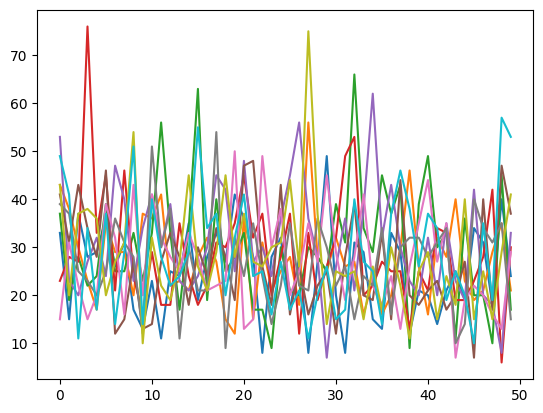

In [16]:
laglist_g2t=range(0,1000,1)
averaged_g2t=[]
for x in range(140,150,1):
    g2t=compute_g2t_wo_kernel_line(img,x,laglist_g2t)
    averaged_g2t.append(g2t)

In [17]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [18]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

(0.0, 0.2924901185770751)

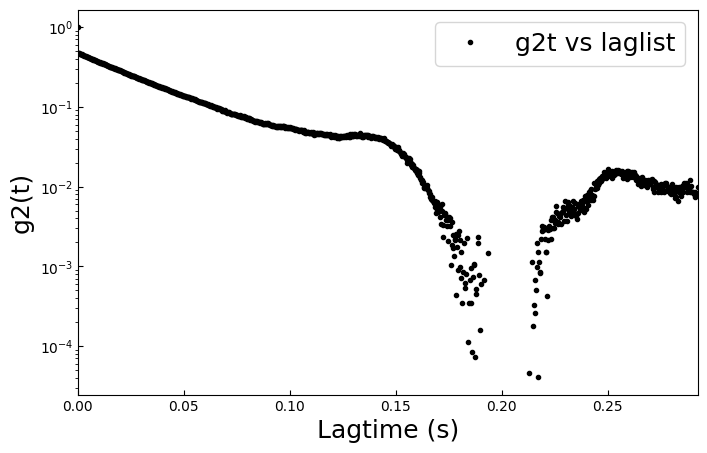

In [24]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[:],average_g2t[:],'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime (s)",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')
plt.yscale('log')
plt.xlim(0,lagtime_g2t[-1])

tau is: 0.037209104950958485
y = -26.87514 * x + -0.74372


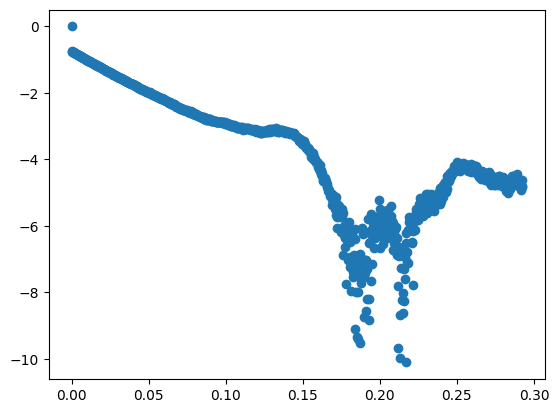

R square is 0.9953819093123171


In [20]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,15, True)

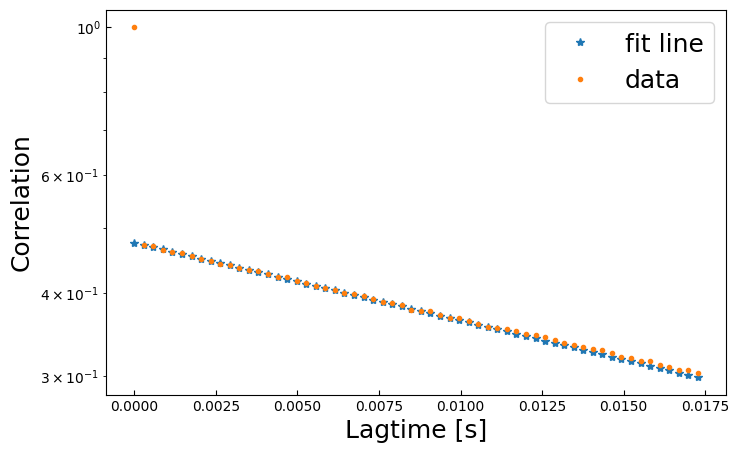

In [21]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [22]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

6.525147900463564e-15


### Average over spatial and temperol 

In [ ]:
def spatial_temporal_line(img, x, kernel_size,t_interest, tau_interest,normalize=True):
    
    
    correlation=np.zeros(len(tau_interest))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size))
    for index,i in enumerate(range(x-kernel_size, x+kernel_size)):
        for t in range(total_tlength):
            intensity[t,index]=img[0,t,0,0,0,i,0]
    print(intensity.shape)
        
    for tau in tau_interest:
        numerator=[]
        denum1=[]
        denum2=[]
        for t in t_interest:
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
        correlation[tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
    if normalize:
        first=correlation[0]
        for tau in tau_interest:
            correlation[tau]=correlation[tau]/first   
    

    return correlation

In [ ]:
print(img.shape[1])

In [ ]:
tau_interest=range(0,1000,1)
t_interest=range(0,15000,1)
averaged_g2t=[]
x=125
g2t=spatial_temporal_line(img,110,100,t_interest,tau_interest)

In [ ]:
g2t.shape

In [ ]:
lagtime_g2t=tau_interest
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[:],g2t[:],'.')
plt.legend(['Spatemp vs laglist'], fontsize=18)
plt.xlabel("Lagtime (s)",fontsize=18)
plt.ylabel("Spatial temperol Corr",fontsize=18)
plt.tick_params(direction='in')

In [ ]:
laglist_g2t=tau_interest
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,15, True)

In [ ]:
len(lagtime_g2t)

In [ ]:
reconstruct(lagtime_g2t[0:100],plateau,np.array(g2t[0:100]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [ ]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

#plot distribution

In [ ]:
Ibar=31.2
I=np.linspace(0,255,5000)

In [ ]:
p_I=(1/Ibar)*np.exp(-I/Ibar)

In [ ]:
plt.plot(I,p_I)

In [ ]:
au=[0.26, 0.52, 0.78, 1]
contrast=[0.618226049,0.495740801,0.413857826,0.35796003]
plt.plot(au,contrast,'k')
plt.tick_params(bottom=True, top=True, left=True, right=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.xlabel('Airy Unit (A.U.)',size=18)
plt.ylabel('C',size=18)


In [ ]:
measured_size=[411,457,477,491]
psf=[351,395,432,450]

In [ ]:
plt.plot(au,measured_size,'k.',label='measured speckle size')
plt.plot(au,psf,'b.',label='point spread function')
plt.tick_params(bottom=True, top=True, left=True, right=True,direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,550)
plt.xlabel('Airy Unit (A.U.)',size=18)
plt.ylabel('Size (nm)',size=18)
plt.legend(fontsize=18)